## Using a CNN model

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [9]:
# Following the same code as in training_a_model notebook, but using a CNN model

training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

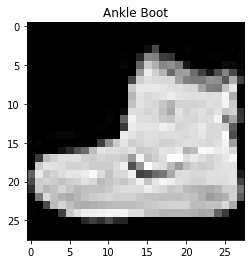

In [12]:
# Look at a sample of the data
x, y = next(iter(training_data))

plt.figure()
plt.imshow(x.squeeze(), cmap="gray")
plt.title(labels_map[y])
plt.show()

In [45]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.relu = nn.ReLU()
        # The output of a convo layer will be (W - K + 2P) / S + 1, where W is the
        # image size, K is the kernel size, P is the padding size, and S is the stride.
        # My input images are 1 x 28 x 28 and will be output as 6 x 30 x 30.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=2)
        # The output of a pooling layer will be (W - K) / S + 1, where K is the pooling kernel
        # and S is the stride. So input 6 x 30 x 30 images will be output as 6 x 14 x 14.
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input: 6 x 14 x 14, Output: 16 x 12 x 12
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1)
        # Input: 16 x 12 x 12, Output: 16 x 6 x 6
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers. All 16*6*6 inputs connect to 120 outputs, connecting the
        # convolutional layers to the FC layers.
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        # 120 input nodes to 84 output nodes
        self.fc2 = nn.Linear(120, 84)
        # 84 input nodes to 10 output nodes: the number of labels
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        # If the size is a square you can only specify a single number
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (relu): ReLU()
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [46]:
epochs = 10
batch_size = 64
learning_rate = 1e-3
momentum = 0.9
weight_decay = 0.0005

In [47]:
# Initialize the dataloaders and model
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

model = Net()
model.to(device)

Net(
  (relu): ReLU()
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  momentum=momentum, weight_decay=weight_decay)

In [49]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Get the input data X and label y from the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # Compute the model prediction given current model parameters.
        pred = model(X.to(device))
        # Compute the loss from the prediction and the label
        loss = loss_fn(pred, y.to(device))

        # Optimization: zero gradients, backpropogation, adjust parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    # Turn off grad computation to reduce overhead of forward pass for testing.
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            # Accumulate the total loss on the test data.
            test_loss += loss_fn(pred, y.to(device)).item()
            # Count the number of correct answers to calculate the accuracy.
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    # Compute average loss and the overall accuracy of the model.
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [50]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 17.2%, Avg loss: 0.036040 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 64.4%, Avg loss: 0.014718 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.011319 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.010288 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.009201 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.008522 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.007986 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.007564 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.007327 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.007090 

Done!
